# IFN646 All Models

In [1]:
import pandas as pd
import numpy as np
import glob
import re
import os

from io import StringIO

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import plot_confusion_matrix

import missingno
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filenames = glob.glob('IFN646_project/' + "*.csv")
dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

    
for i in range(len(dfs)):
#     print(filenames[i])
    # adding the participants number index 16
    start = filenames[i].find("/p")
    end = filenames[i].find("_n")
    dfs[i]['participant'] = filenames[i][start + 2:end]  

    # adding night number # index 21
    start = filenames[i].find("_n")
    end = filenames[i].find("_r")
    dfs[i]['night'] = filenames[i][start + 2:end]
        
    # filling actiware all classification with 1, as the missing value are in the beginning and in the end and it seems to be the wake up time
    dfs[i]['Actiware classification'] = dfs[i]['Actiware classification'].fillna(1)
    # filling all the ENMO value with mean by dataframe
    dfs[i]['Apple Watch ENMO'] = dfs[i]['Apple Watch ENMO'].fillna(dfs[i]['Apple Watch ENMO'].mean())
    # filling actiwatch activity counts with mean
    dfs[i]['Actiwatch activity counts'] = dfs[i]['Actiwatch activity counts'].fillna(dfs[i]['Apple Watch ENMO'].mean())
    
    # set timestamp as index
    dfs[i].set_index('timestamp')

#     # convert datetime to time data type
#     dfs[i].timestamp = pd.to_datetime(dfs[i].timestamp)
#     sn.heatmap(dfs[i].isnull(), cbar = False)
#     plt.show()
    

In [3]:
sleepwake = pd.concat(dfs)

In [4]:
sleepwake['participant'] = sleepwake.participant.astype("category")
sleepwake.night = sleepwake.night.astype(int)
sleepwake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49312 entries, 0 to 2423
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   timestamp                  49312 non-null  object  
 1   Actiwatch activity counts  49312 non-null  float64 
 2   Actiware classification    49312 non-null  float64 
 3   Apple Watch ENMO           49312 non-null  float64 
 4   participant                49312 non-null  category
 5   night                      49312 non-null  int64   
dtypes: category(1), float64(3), int64(1), object(1)
memory usage: 2.3+ MB


In [5]:
sleepwake.describe()

,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,night
count,49312.000000,49312.000000,49312.000000,49312.000000
mean,4.092821,0.086977,0.006620,1.453602
std,24.509936,0.281804,0.029232,0.497848
min,0.000000,0.000000,0.000505,1.000000
25%,0.000000,0.000000,0.001898,1.000000
50%,0.000000,0.000000,0.003030,1.000000
75%,0.000000,0.000000,0.004748,2.000000
max,880.000000,1.000000,3.342039,2.000000


In [6]:
sleepwake.head()

,timestamp,Actiwatch activity counts,Actiware classification,Apple Watch ENMO,participant,night
0,06/01/2000 22:11:00,0.004406,1.0,0.047328,05,1
1,06/01/2000 22:11:15,91.000000,1.0,0.049485,05,1
2,06/01/2000 22:11:30,62.000000,1.0,0.047339,05,1
3,06/01/2000 22:11:45,58.000000,1.0,0.069403,05,1
4,06/01/2000 22:12:00,154.000000,1.0,1.066049,05,1


In [7]:
# rename column name
sleepwake.rename(columns = {'Actiwatch activity counts' : 'actiwatch_counts',
                           'Actiware classification' : 'actiware_class',
                           'Apple Watch ENMO' : 'Apple_ENMO'}, inplace = True)
sleepwake.head()

,timestamp,actiwatch_counts,actiware_class,Apple_ENMO,participant,night
0,06/01/2000 22:11:00,0.004406,1.0,0.047328,05,1
1,06/01/2000 22:11:15,91.000000,1.0,0.049485,05,1
2,06/01/2000 22:11:30,62.000000,1.0,0.047339,05,1
3,06/01/2000 22:11:45,58.000000,1.0,0.069403,05,1
4,06/01/2000 22:12:00,154.000000,1.0,1.066049,05,1


In [8]:
sleepwake = sleepwake[sleepwake['actiware_class'].notna()]
sleepwake = sleepwake[sleepwake['actiwatch_counts'].notna()]
sleepwake = sleepwake[sleepwake['Apple_ENMO'].notna()]

In [9]:
sleepwake.head()

,timestamp,actiwatch_counts,actiware_class,Apple_ENMO,participant,night
0,06/01/2000 22:11:00,0.004406,1.0,0.047328,05,1
1,06/01/2000 22:11:15,91.000000,1.0,0.049485,05,1
2,06/01/2000 22:11:30,62.000000,1.0,0.047339,05,1
3,06/01/2000 22:11:45,58.000000,1.0,0.069403,05,1
4,06/01/2000 22:12:00,154.000000,1.0,1.066049,05,1


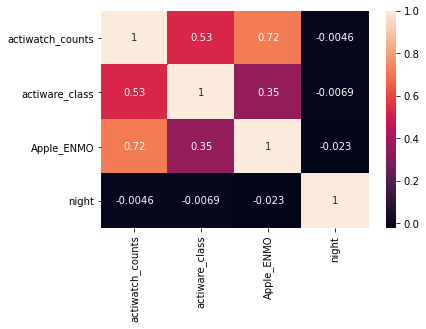

In [10]:
corrMatrix = sleepwake.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

## Exploratory Analysis

- number of training night and average threshold (boxplot)
- roc for varying threshold, apple watch threshold

In [11]:
# output = actiware_class
# input = actiwatch_counts / Apple_ENMO

Text(6.800000000000004, 0.5, 'Apple ENMO')

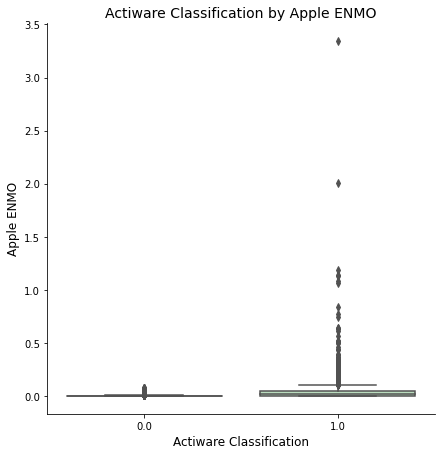

In [68]:
sn.catplot(x="actiware_class", y="Apple_ENMO", kind="box", data=sleepwake
          ,palette="GnBu_r", height=6, aspect=9/9)
plt.title("Actiware Classification by Apple ENMO", fontsize=14)
plt.xlabel("Actiware Classification", fontsize=12)
plt.ylabel("Apple ENMO", fontsize=12) 

Text(3.6750000000000043, 0.5, 'Actiwatch Counts')

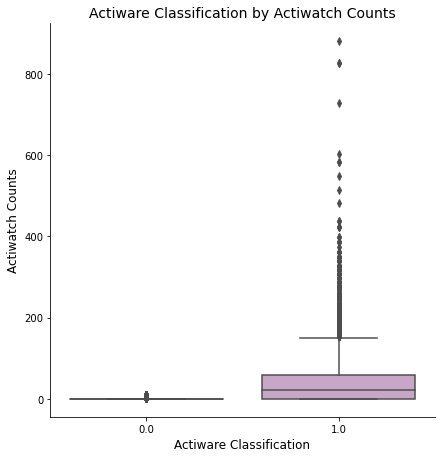

In [69]:
sn.catplot(x="actiware_class", y="actiwatch_counts", kind="box", data=sleepwake
          ,palette="PuRd_r", height=6, aspect=9/9)
plt.title("Actiware Classification by Actiwatch Counts", fontsize=14)
plt.xlabel("Actiware Classification", fontsize=12)
plt.ylabel("Actiwatch Counts", fontsize=12) 


(0.0, 70.0)

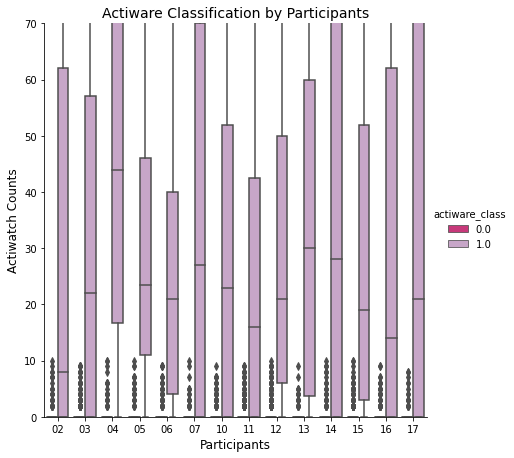

In [14]:
sn.catplot(x="participant", y="actiwatch_counts", hue = "actiware_class", kind="box", data=sleepwake
          ,palette="PuRd_r", height=6, aspect=9/9)
plt.title("Actiware Classification by Participants", fontsize=14)
plt.xlabel("Participants", fontsize=12)
plt.ylabel("Actiwatch Counts", fontsize=12) 
plt.ylim(0.0,70)

(0.0, 0.05)

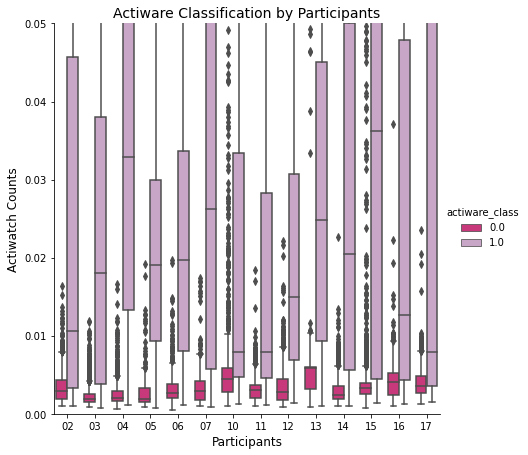

In [15]:
sn.catplot(x="participant", y="Apple_ENMO", hue = "actiware_class", kind="box", data=sleepwake
          ,palette="PuRd_r", height=6, aspect=9/9)
plt.title("Actiware Classification by Participants", fontsize=14)
plt.xlabel("Participants", fontsize=12)
plt.ylabel("Actiwatch Counts", fontsize=12) 
plt.ylim(0.0,0.05)

### Train Test Split

In [16]:
x = sleepwake[['actiwatch_counts', 'Apple_ENMO']]
y = sleepwake['actiware_class']

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state=10)

### Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
randomforest = RandomForestClassifier(n_estimators = 100)
randomforest_model = randomforest.fit(x_train[['Apple_ENMO']], y_train)
y_predicted_r = randomforest.predict(x_test[['Apple_ENMO']])

randomforest_ac = RandomForestClassifier(n_estimators = 100)
randomforest_model_ac = randomforest_ac.fit(x_train[['actiwatch_counts']], y_train)
y_predicted_r_ac = randomforest_ac.predict(x_test[['actiwatch_counts']])

In [19]:
print("Train accuracy:", randomforest.score(x_train[['Apple_ENMO']], y_train))

Train accuracy: 0.9815458601309461


In [20]:
print("Test accuracy:", randomforest.score(x_test[['Apple_ENMO']], y_test))

Test accuracy: 0.936798702176558


In [21]:
print("Train accuracy:", randomforest_ac.score(x_train[['actiwatch_counts']], y_train))

Train accuracy: 0.9741294397126137


In [22]:
print("Test accuracy:", randomforest_ac.score(x_test[['actiwatch_counts']], y_test))

Test accuracy: 0.9726916317425983


In [23]:
# k-fold cross validation to evaluate the performance of the model
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(estimator = randomforest, X = x_train, y = y_train, cv =10)
accuracy.mean()

0.9625700713817313

In [24]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_predicted_r)
cnf_matrix

array([[13145,   374],
       [  561,   714]])

In [25]:
cnf_matrix_ac = metrics.confusion_matrix(y_test, y_predicted_r_ac)
cnf_matrix_ac

array([[13494,    25],
       [  379,   896]])

In [26]:
from sklearn.metrics import plot_confusion_matrix

In [27]:
def eval_model(model, x_train, y_train, x_test, y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, x_train, y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == y_train)/len(y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, x_test, y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(x_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == y_test)/len(y_test)));


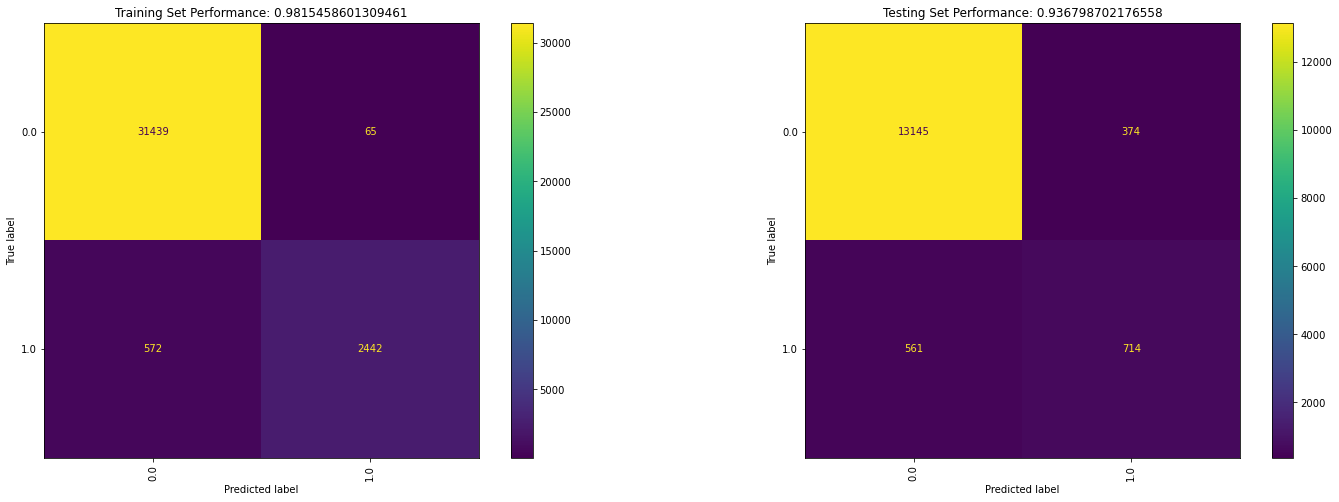

In [28]:
eval_model(randomforest, x_train[['Apple_ENMO']], y_train, x_test[['Apple_ENMO']], y_test)

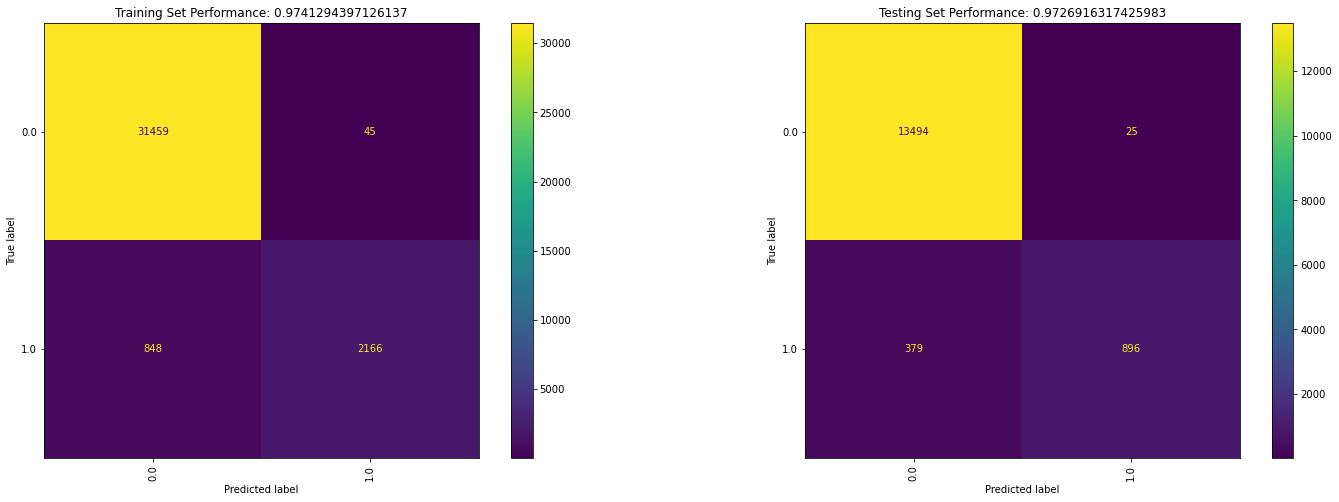

In [29]:
eval_model(randomforest_ac, x_train[['actiwatch_counts']], y_train,
           x_test[['actiwatch_counts']], y_test)

Text(0.5, 1.0, 'DET Curve')

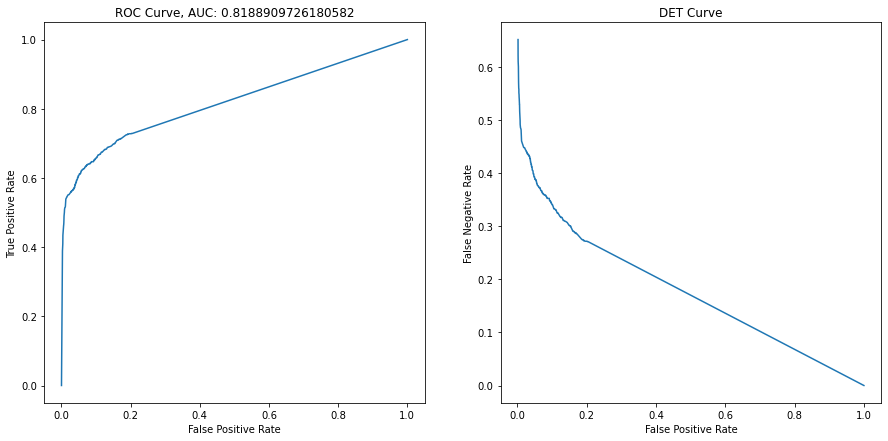

In [30]:
from sklearn.metrics import roc_curve, det_curve, roc_auc_score, auc

scores = randomforest.predict_proba(x_test[['Apple_ENMO']])

fig = plt.figure(figsize=[15, 7])
fpr, tpr, thresholds = roc_curve(y_test, scores[:, 1])
auc_score = roc_auc_score(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve, AUC: ' + str(auc_score))

fpr, fnr, thresholds = det_curve(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 2)
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(y_test, randomforest.predict(x_test[['Apple_ENMO']])))

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13519
         1.0       0.66      0.56      0.60      1275

    accuracy                           0.94     14794
   macro avg       0.81      0.77      0.78     14794
weighted avg       0.93      0.94      0.93     14794



In [32]:
print(classification_report(y_test, randomforest_ac.predict(x_test[['actiwatch_counts']])))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.99     13519
         1.0       0.97      0.70      0.82      1275

    accuracy                           0.97     14794
   macro avg       0.97      0.85      0.90     14794
weighted avg       0.97      0.97      0.97     14794



In [33]:
from sklearn.model_selection import cross_val_score
print(np.mean(cross_val_score(randomforest, x_train[['Apple_ENMO']], y_train, cv=10)))

0.9365548233118315


In [34]:
print(np.mean(cross_val_score(randomforest_ac, x_train[['actiwatch_counts']], y_train, cv=10)))

0.9741293436701808


# Logistic Regression

In [35]:
x_train

,actiwatch_counts,Apple_ENMO
188,0.0,0.001598
1274,0.0,0.001120
866,12.0,0.011509
532,0.0,0.002606
129,0.0,0.004637
...,...,...
2439,0.0,0.002007
1685,0.0,0.005229
883,229.0,0.205872
2441,0.0,0.002070


In [36]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(x_train[['Apple_ENMO']], y_train)
y_pred = logreg.predict(x_test[['Apple_ENMO']])

logreg_2 = LogisticRegression()
logreg_2.fit(x_train[['actiwatch_counts']], y_train)
y_pred_2 = logreg.predict(x_test[['actiwatch_counts']])


In [37]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print("Confusion Matrix for Apple Watch ENMO")
print(cnf_matrix)

Confusion Matrix for Apple Watch ENMO
[[13518     1]
 [ 1096   179]]


In [38]:
cnf_matrix2 = metrics.confusion_matrix(y_test, y_pred_2)
print("Confusion Matrix for Actiwatch activity counts")
print(cnf_matrix2)

Confusion Matrix for Actiwatch activity counts
[[13291   228]
 [  383   892]]


In [39]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = plot_confusion_matrix(model, X_train, Y_train, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: ' + str(sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = plot_confusion_matrix(model, X_test, Y_test, normalize=None, xticks_rotation='vertical', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Testing Set Performance: ' + str(sum(pred == Y_test)/len(Y_test)));


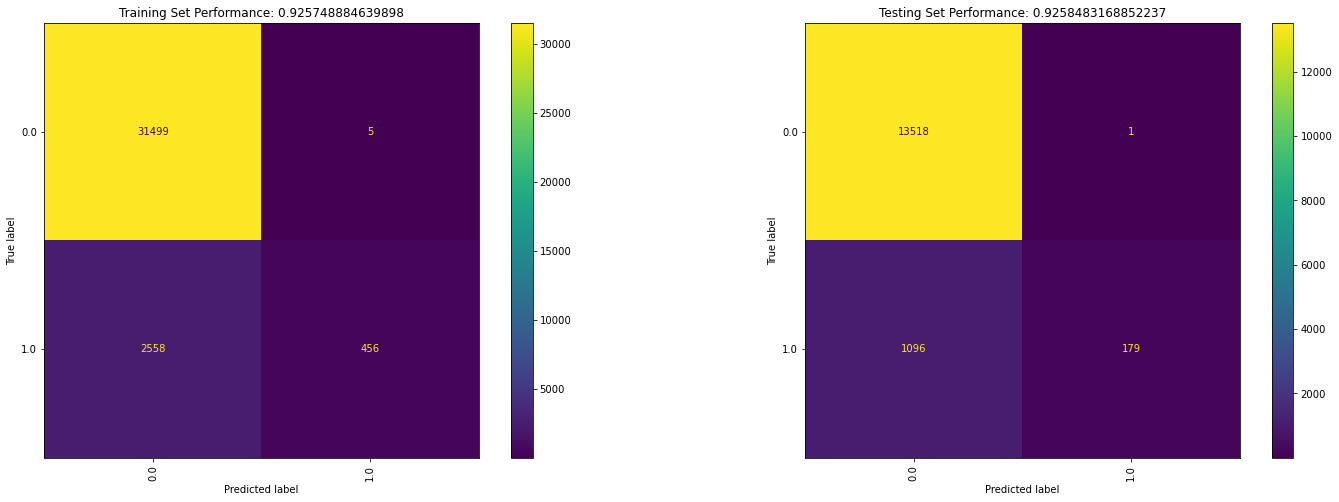

In [40]:
eval_model(logreg, x_train[['Apple_ENMO']], y_train, x_test[['Apple_ENMO']], y_test)

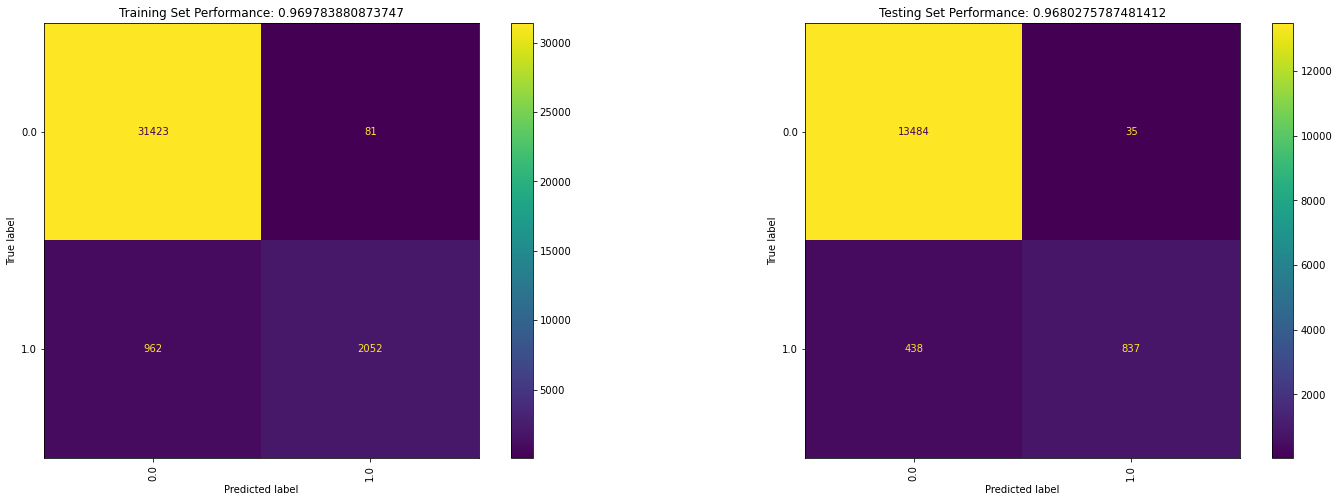

In [41]:
eval_model(logreg_2, x_train[['actiwatch_counts']], y_train, x_test[['actiwatch_counts']], y_test)

Text(0.5, 1.0, 'DET Curve')

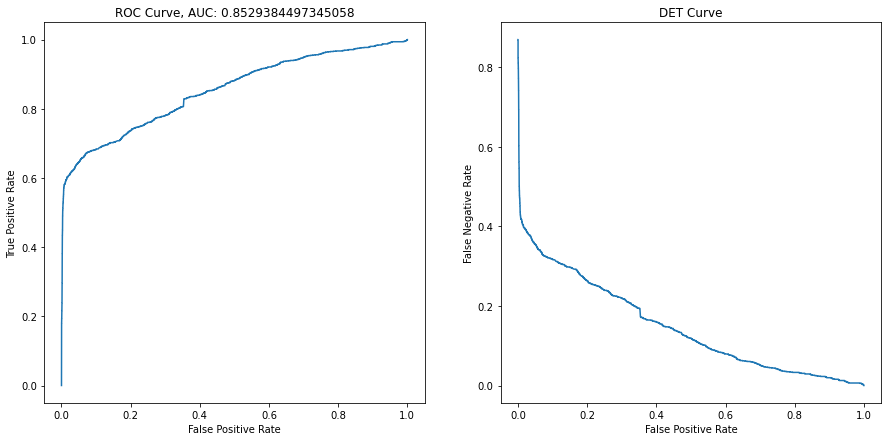

In [42]:
from sklearn.metrics import roc_curve, det_curve, roc_auc_score, auc

scores = logreg.predict_proba(x_test[['Apple_ENMO']])

fig = plt.figure(figsize=[15, 7])
fpr, tpr, thresholds = roc_curve(y_test, scores[:, 1])
auc_score = roc_auc_score(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve, AUC: ' + str(auc_score))

fpr, fnr, thresholds = det_curve(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 2)
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
print(classification_report(y_test, logreg.predict(x_test[['Apple_ENMO']])))

              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96     13519
         1.0       0.99      0.14      0.25      1275

    accuracy                           0.93     14794
   macro avg       0.96      0.57      0.60     14794
weighted avg       0.93      0.93      0.90     14794



In [44]:
# k-fold cross validation to evaluate the performance of the model
from sklearn.linear_model import LogisticRegressionCV
clflogreg = LogisticRegressionCV(cv=10, random_state=0).fit(x[['Apple_ENMO']],y)
clflogreg.predict(x[['Apple_ENMO']])
clflogreg.predict_proba(x[['Apple_ENMO']]).shape
clflogreg.score(x[['Apple_ENMO']],y)

0.9521414665801428

In [45]:
clflogreg = LogisticRegressionCV(cv=10, random_state=0).fit(x[['Apple_ENMO']],y)
clflogreg.predict(x[['Apple_ENMO']])
clflogreg.predict_proba(x[['Apple_ENMO']]).shape
clflogreg.score(x[['Apple_ENMO']],y)

0.9521414665801428

# Neural Network

In [46]:
rs = 200
model_1 = MLPClassifier(random_state=rs)
model_1.fit(x_train, y_train)

print("Train accuracy:", model_1.score(x_train, y_train))
print("Test accuracy:", model_1.score(x_test, y_test))

y_pred = model_1.predict(x_test)

print(classification_report(y_test, y_pred))

print(model_1)

Train accuracy: 0.9722173938235124
Test accuracy: 0.9703258077599026
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     13519
         1.0       0.96      0.69      0.80      1275

    accuracy                           0.97     14794
   macro avg       0.96      0.84      0.89     14794
weighted avg       0.97      0.97      0.97     14794

MLPClassifier(random_state=200)


In [47]:
model_2 = MLPClassifier(max_iter=10000, random_state=rs)
model_2.fit(x_train, y_train)

print("Train accuracy:", model_2.score(x_train, y_train))
print("Test accuracy:", model_2.score(x_test, y_test))

y_pred = model_2.predict(x_test)
print(classification_report(y_test, y_pred))

print(model_2)

Train accuracy: 0.9722173938235124
Test accuracy: 0.9703258077599026
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     13519
         1.0       0.96      0.69      0.80      1275

    accuracy                           0.97     14794
   macro avg       0.96      0.84      0.89     14794
weighted avg       0.97      0.97      0.97     14794

MLPClassifier(max_iter=10000, random_state=200)


In [48]:
model_3 = MLPClassifier(max_iter=10000, random_state=rs)
model_3.fit(x_train[['Apple_ENMO']], y_train)

print("Train accuracy:", model_3.score(x_train[['Apple_ENMO']], y_train))
print("Test accuracy:", model_3.score(x_test[['Apple_ENMO']], y_test))

y_pred = model_3.predict(x_test[['Apple_ENMO']])
print(classification_report(y_test, y_pred))

print(model_3)

Train accuracy: 0.9563995596500376
Test accuracy: 0.9553197242125185
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98     13519
         1.0       0.91      0.54      0.67      1275

    accuracy                           0.96     14794
   macro avg       0.93      0.77      0.82     14794
weighted avg       0.95      0.96      0.95     14794

MLPClassifier(max_iter=10000, random_state=200)


In [62]:
model_4 = MLPClassifier(max_iter=10000, random_state=rs)
model_4.fit(x_train[['actiwatch_counts']], y_train)

print("Train accuracy:", model_3.score(x_train[['actiwatch_counts']], y_train))
print("Test accuracy:", model_3.score(x_test[['actiwatch_counts']], y_test))

y_pred4 = model_4.predict(x_test[['actiwatch_counts']])
print(classification_report(y_test, y_pred4))

print(model_4)

Train accuracy: 0.9602815922127586
Test accuracy: 0.9586994727592267
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     13519
         1.0       0.96      0.66      0.78      1275

    accuracy                           0.97     14794
   macro avg       0.96      0.83      0.88     14794
weighted avg       0.97      0.97      0.97     14794

MLPClassifier(max_iter=10000, random_state=200)


In [49]:
params = {'hidden_layer_sizes': [(x,) for x in range(5, 86, 20)]}

cv_1 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv_1.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=MLPClassifier(random_state=200), n_jobs=-1,
             param_grid={'hidden_layer_sizes': [(5,), (25,), (45,), (65,),
                                                (85,)]},
             return_train_score=True)

In [50]:
result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([ 2.48950875,  8.09904261, 10.12057571, 13.30831356, 14.09092808]), 'std_fit_time': array([0.01834809, 0.40452232, 1.04801842, 1.69608277, 6.13552245]), 'mean_score_time': array([0.0040509 , 0.00526021, 0.0055563 , 0.00800385, 0.00573664]), 'std_score_time': array([0.00060887, 0.00121811, 0.00121331, 0.00169146, 0.00174655]), 'param_hidden_layer_sizes': masked_array(data=[(5,), (25,), (45,), (65,), (85,)],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'hidden_layer_sizes': (5,)}, {'hidden_layer_sizes': (25,)}, {'hidden_layer_sizes': (45,)}, {'hidden_layer_sizes': (65,)}, {'hidden_layer_sizes': (85,)}], 'split0_test_score': array([0.97421784, 0.97537659, 0.97479722, 0.97479722, 0.97479722]), 'split1_test_score': array([0.96900348, 0.96987254, 0.96900348, 0.96900348, 0.9684241 ]), 'split2_test_score': array([0.96697567, 0.96813441, 0.96813441, 0.96813441, 0.96813441]), 'split3_test_score': arra

Total number of models:  5


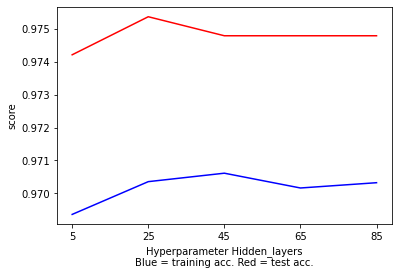

In [51]:
train_result = result_set['split0_train_score']
test_result = result_set['split0_test_score']
print("Total number of models: ", len(test_result))
# plot hidden layers hyperparameter values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter Hidden_layers\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),range(5, 86, 20))
plt.ylabel('score')
plt.show()

In [52]:
print("Train accuracy:", cv_1.score(x_train, y_train))
print("Test accuracy:", cv_1.score(x_test, y_test))

y_pred = cv_1.predict(x_test)
print(classification_report(y_test, y_pred))

print(cv_1.best_params_)

Train accuracy: 0.9709137261718523
Test accuracy: 0.9688387183993511
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     13519
         1.0       0.96      0.67      0.79      1275

    accuracy                           0.97     14794
   macro avg       0.96      0.83      0.89     14794
weighted avg       0.97      0.97      0.97     14794

{'hidden_layer_sizes': (45,)}


In [53]:
params = {'hidden_layer_sizes': [(3,), (5,), (7,), (9,)], 'alpha': [0.01,0.001, 0.0001, 0.00001]}

cv_3 = GridSearchCV(param_grid=params, estimator=MLPClassifier(random_state=rs), cv=10, n_jobs=-1)
cv_3.fit(x_train, y_train)

print("Train accuracy:", cv_3.score(x_train, y_train))
print("Test accuracy:", cv_3.score(x_test, y_test))

y_pred = cv_3.predict(x_test)
print(classification_report(y_test, y_pred))

print(cv_3.best_params_)

Train accuracy: 0.969783880873747
Test accuracy: 0.9681627686900095
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     13519
         1.0       0.96      0.66      0.78      1275

    accuracy                           0.97     14794
   macro avg       0.96      0.83      0.88     14794
weighted avg       0.97      0.97      0.97     14794

{'alpha': 0.0001, 'hidden_layer_sizes': (9,)}


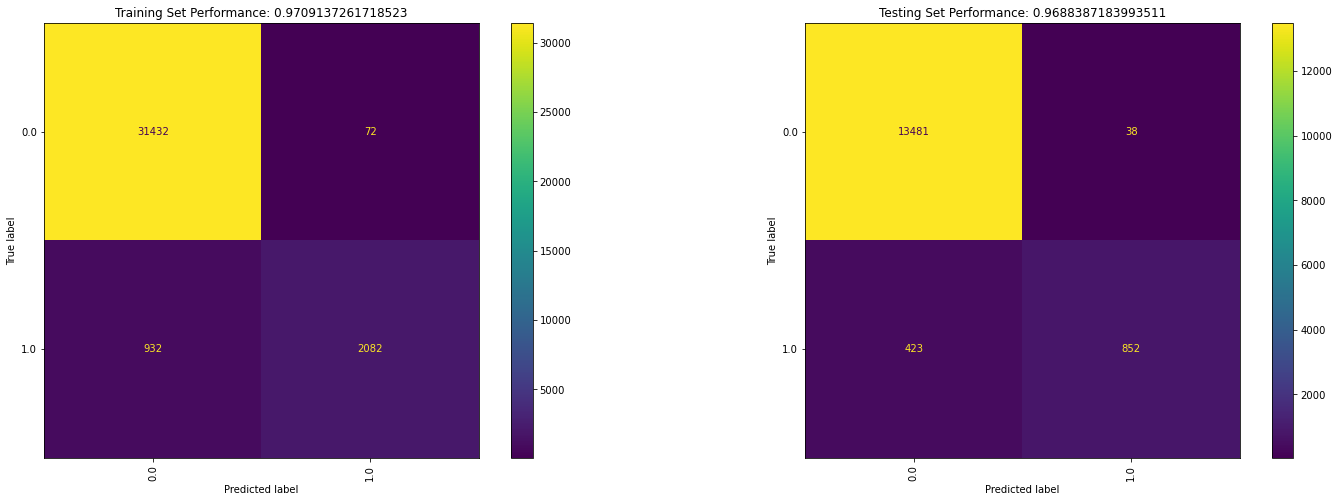

In [54]:
eval_model(cv_1, x_train, y_train, x_test, y_test)

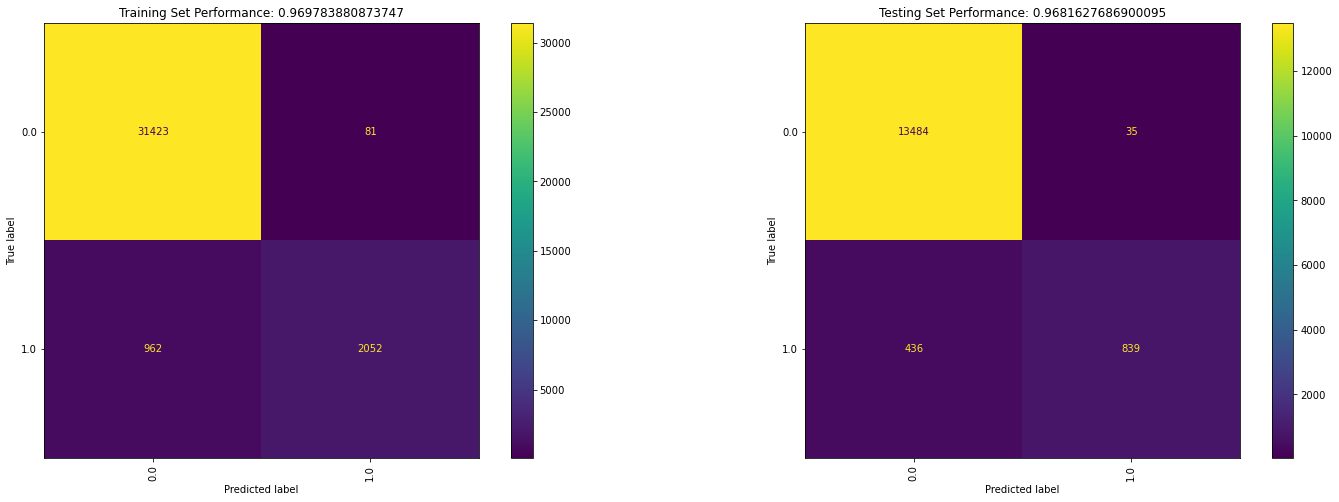

In [55]:
eval_model(cv_3, x_train, y_train, x_test, y_test)

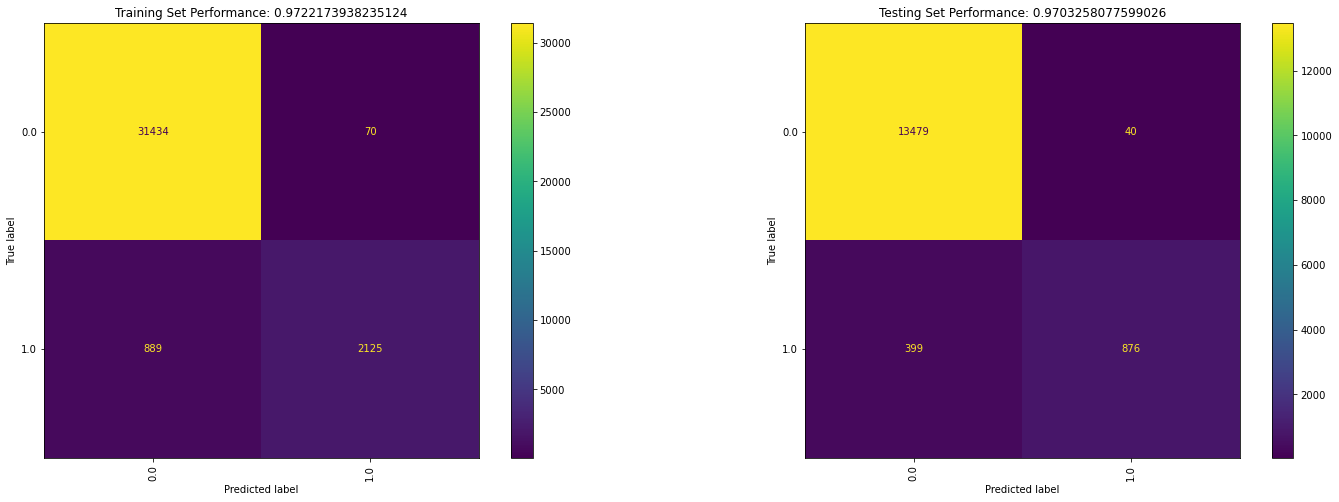

In [56]:
eval_model(model_1, x_train, y_train, x_test, y_test)

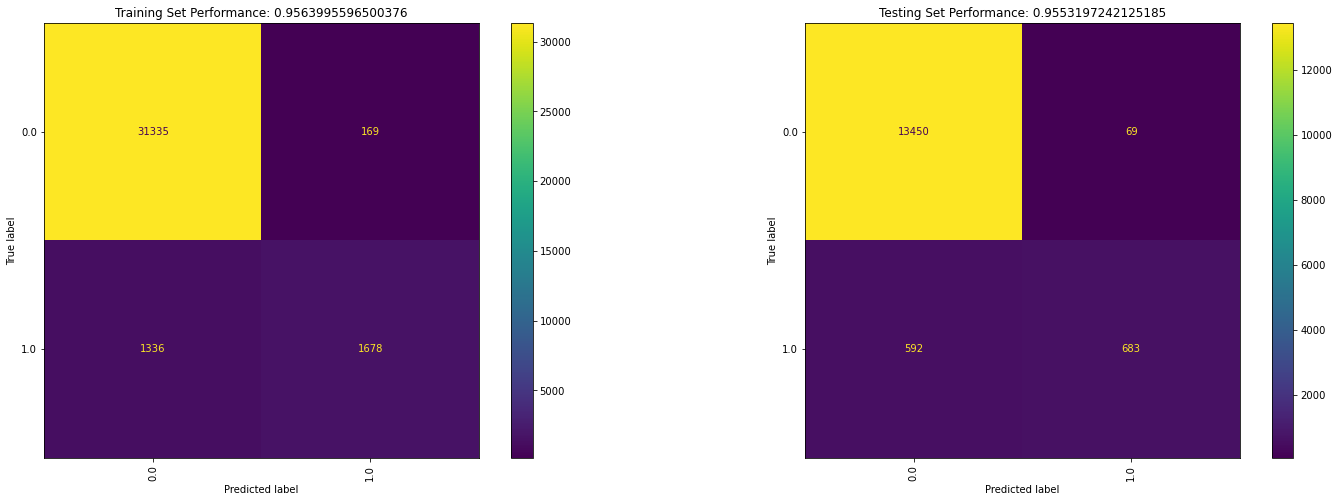

In [57]:
eval_model(model_3, x_train[['Apple_ENMO']], y_train, x_test[['Apple_ENMO']], y_test)

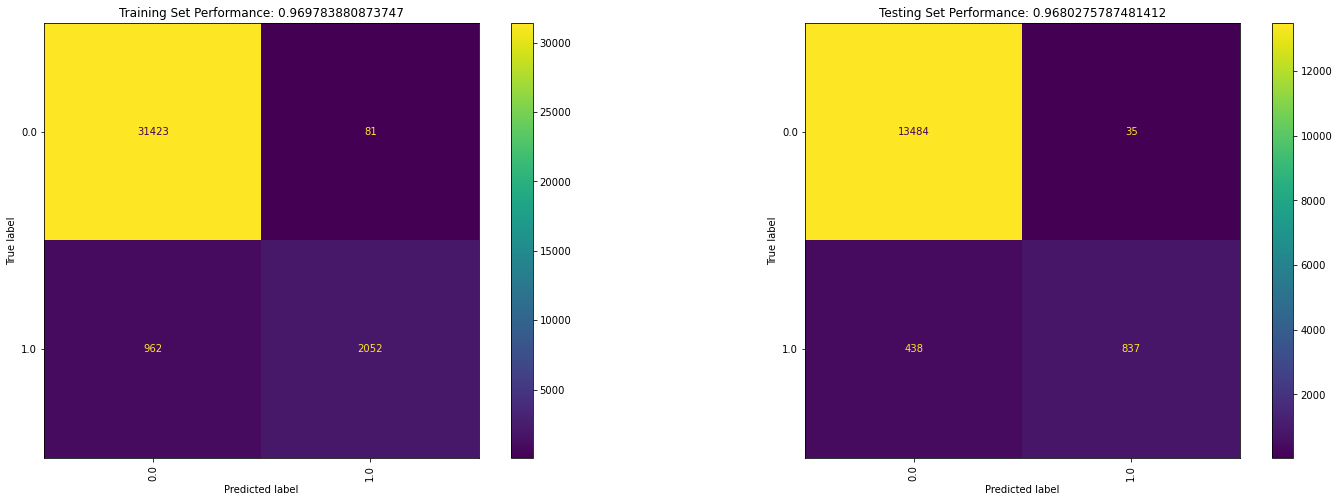

In [63]:
eval_model(model_4, x_train[['actiwatch_counts']], y_train, x_test[['actiwatch_counts']], y_test)

Text(0.5, 1.0, 'DET Curve')

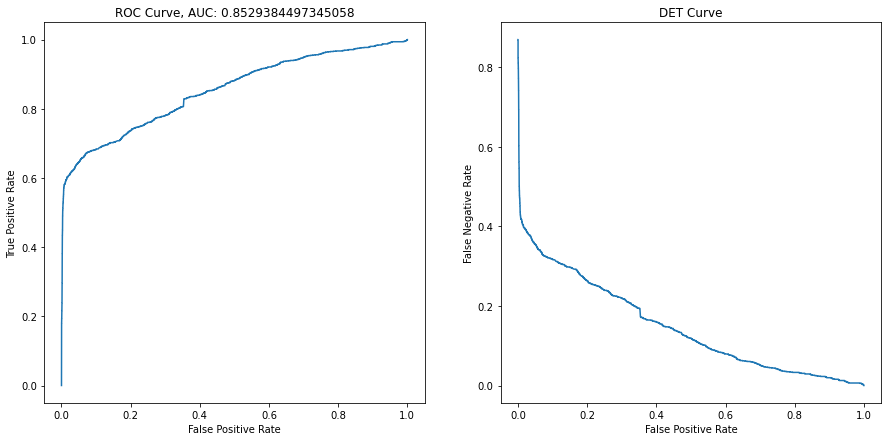

In [60]:
from sklearn.metrics import roc_curve, det_curve, roc_auc_score, auc

scores = model_3.predict_proba(x_test[['Apple_ENMO']])

fig = plt.figure(figsize=[15, 7])
fpr, tpr, thresholds = roc_curve(y_test, scores[:, 1])
auc_score = roc_auc_score(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 1)
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve, AUC: ' + str(auc_score))

fpr, fnr, thresholds = det_curve(y_test, scores[:, 1])
ax = fig.add_subplot(1, 2, 2)
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')

# Comparing three model

ROC index on test for RF : 0.8188909726180582
ROC index on test for LG : 0.8529384497345058
ROC index on test for NN : 0.8529384497345058
ROC index on test for RF_AC : 0.8751537197466457
ROC index on test for LG_AC : 0.8742357379374562
ROC index on test for NN_AC : 0.8742357379374562


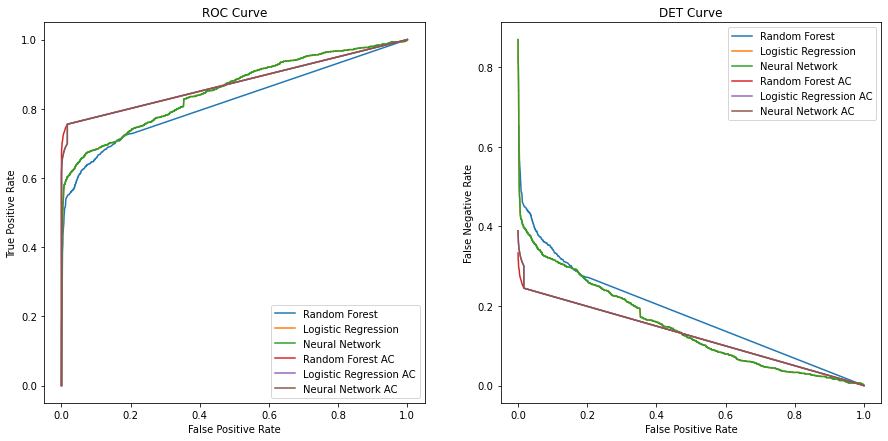

In [67]:
rf_scores = randomforest_model.predict_proba(x_test[['Apple_ENMO']])
lg_scores = logreg.predict_proba(x_test[['Apple_ENMO']])
nn_scores = model_3.predict_proba(x_test[['Apple_ENMO']])
rf_scores_ac = randomforest_ac.predict_proba(x_test[['actiwatch_counts']])
lg_scores_ac = logreg_2.predict_proba(x_test[['actiwatch_counts']])
nn_scores_ac = model_4.predict_proba(x_test[['actiwatch_counts']])


roc_index_rf = roc_auc_score(y_test, rf_scores[:, 1])
roc_index_lg = roc_auc_score(y_test, lg_scores[:, 1])
roc_index_nn = roc_auc_score(y_test, nn_scores[:, 1])

roc_index_rf_ac = roc_auc_score(y_test, rf_scores_ac[:, 1])
roc_index_lg_ac = roc_auc_score(y_test, lg_scores_ac[:, 1])
roc_index_nn_ac = roc_auc_score(y_test, nn_scores_ac[:, 1])

print("ROC index on test for RF :", roc_index_rf)
print("ROC index on test for LG :", roc_index_lg)
print("ROC index on test for NN :", roc_index_nn)

print("ROC index on test for RF_AC :", roc_index_rf_ac)
print("ROC index on test for LG_AC :", roc_index_lg_ac)
print("ROC index on test for NN_AC :", roc_index_nn_ac)

fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(y_test, rf_scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, lg_scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, nn_scores[:, 1])
ax.plot(fpr, tpr)

fpr, tpr, thresholds = roc_curve(y_test, rf_scores_ac[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, lg_scores_ac[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, nn_scores_ac[:, 1])
ax.plot(fpr, tpr)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(['Random Forest', 'Logistic Regression', 'Neural Network', 'Random Forest AC', 'Logistic Regression AC', 'Neural Network AC'])

ax = fig.add_subplot(1, 2, 2)
fpr, fnr, thresholds = det_curve(y_test, rf_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, lg_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, nn_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, rf_scores_ac[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, lg_scores_ac[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, nn_scores_ac[:, 1])
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')
ax.legend(['Random Forest', 'Logistic Regression', 'Neural Network', 'Random Forest AC', 'Logistic Regression AC', 'Neural Network AC'])

In [ ]:
rf_scores = randomforest_ac.predict_proba(x_test[['Apple_ENMO']])
lg_scores = logreg.predict_proba(x_test[['Apple_ENMO']])
nn_scores = model_3.predict_proba(x_test[['Apple_ENMO']])

roc_index_rf = roc_auc_score(y_test, rf_scores[:, 1])
roc_index_lg = roc_auc_score(y_test, lg_scores[:, 1])
roc_index_nn = roc_auc_score(y_test, nn_scores[:, 1])

print("ROC index on test for RF :", roc_index_rf)
print("ROC index on test for LG :", roc_index_lg)
print("ROC index on test for NN :", roc_index_nn)

fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 2, 1)
fpr, tpr, thresholds = roc_curve(y_test, rf_scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, lg_scores[:, 1])
ax.plot(fpr, tpr)
fpr, tpr, thresholds = roc_curve(y_test, nn_scores[:, 1])
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(['Random Forest', 'Logistic Regression', 'Neural Network', 'NN_CV'])

ax = fig.add_subplot(1, 2, 2)
fpr, fnr, thresholds = det_curve(y_test, rf_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, lg_scores[:, 1])
ax.plot(fpr, fnr)
fpr, fnr, thresholds = det_curve(y_test, nn_scores[:, 1])
ax.plot(fpr, fnr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('False Negative Rate')
ax.set_title('DET Curve')
ax.legend(['Random Forest', 'Logistic Regression', 'Neural Network'])

In [ ]:
# statistical analysis
# sleep parameter comparison
# tst


# waso


# number of awakening